<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Personal%20Projects/COVIDadverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explanation of the dataset: https://vaers.hhs.gov/docs/VAERSDataUseGuide_November2020.pdf


In [6]:
import os
import glob
import pandas as pd
import numpy as np
import re
import cv2
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import groupby
from operator import itemgetter
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, classification_report, accuracy_score
from scipy.stats import kruskal, f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors, metrics)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_selection import (f_classif, VarianceThreshold, chi2, mutual_info_classif, SelectKBest,
                                       SelectPercentile, SelectFromModel)
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


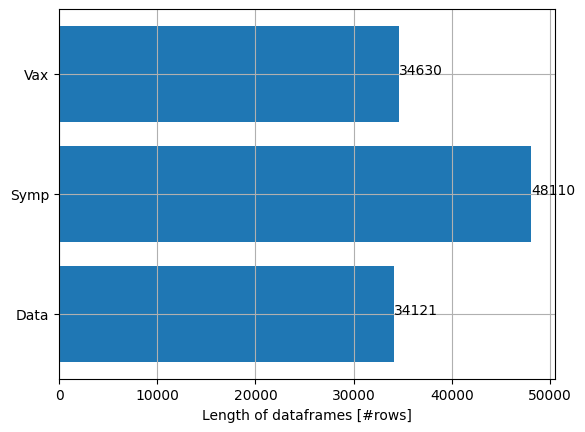

In [8]:
#analysisFolder = '/Users/sbk/Documents/Datasets/Pharmacovigilance/Covid_adverseRx/archive/';
analysisFolder = '/content/drive/MyDrive/Colab Notebooks/Pharmacovigilance/Covid_adverseRx/archive/'
picFolder = analysisFolder + 'Figs'

df_data = pd.read_csv(analysisFolder + '2021VAERSDATA.csv', delimiter=',', encoding='latin-1')
df_symp = pd.read_csv(analysisFolder + '2021VAERSSYMPTOMS.csv', delimiter=',', encoding='latin-1')
df_vax = pd.read_csv(analysisFolder + '2021VAERSVAX.csv', delimiter=',', encoding='latin-1')


x = ['Data', 'Symp', 'Vax']
y = [len(df_data), len(df_symp), len(df_vax)];
plt.barh(x, y)
for i in range(len(x)):
    plt.text(y[i], i, y[i], ha = 'left')
plt.xlabel('Length of dataframes [#rows]')
plt.grid()
plt.show()



In [9]:
#let's explore the data a bit:
df_symp.head(10)

VAERS_ID                   SYMPTOM1  SYMPTOMVERSION1  \
0    916600                  Dysphagia             23.1   
1    916601                    Anxiety             23.1   
2    916602           Chest discomfort             23.1   
3    916603                  Dizziness             23.1   
4    916604    Injection site erythema             23.1   
5    916606        Pharyngeal swelling             23.1   
6    916607             Abdominal pain             23.1   
7    916608                  Diarrhoea             23.1   
8    916609  Vaccination site erythema             23.1   
9    916610                       Rash             23.1   

                    SYMPTOM2  SYMPTOMVERSION2                   SYMPTOM3  \
0               Epiglottitis             23.1                        NaN   
1                   Dyspnoea             23.1                        NaN   
2                  Dysphagia             23.1          Pain in extremity   
3                    Fatigue             23.1         Mobility decreased   
4    Injection site pruritus             23.1    Injection site swelling   
5                        NaN              NaN                        NaN   
6                     Chills             23.1             Sleep disorder   
7           Nasal congestion             23.1                        NaN   
8  Vaccination site pruritus             23.1  Vaccination site swelling   
9                  Urticaria             23.1                        NaN   

   SYMPTOMVERSION3               SYMPTOM4  SYMPTOMVERSION4 SYMPTOM5  \
0              NaN                    NaN              NaN      NaN   
1              NaN                    NaN              NaN      NaN   
2             23.1      Visual impairment             23.1      NaN   
3             23.1                    NaN              NaN      NaN   
4             23.1  Injection site warmth             23.1      NaN   
5              NaN                    NaN              NaN      NaN   
6             23.1                    NaN              NaN      NaN   
7              NaN                    NaN              NaN      NaN   
8             23.1                    NaN              NaN      NaN   
9              NaN                    NaN              NaN      NaN   

   SYMPTOMVERSION5  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
5              NaN  
6              NaN  
7              NaN  
8              NaN  
9              NaN

we group by patient ID:

In [10]:
# Merge df_data with df_symp using 'VAERS_ID' as the key
merged_df = df_data.merge(df_symp, on='VAERS_ID', how='inner')

# Merge the merged_df with df_vax using 'VAERS_ID' as the key
merged_df = merged_df.merge(df_vax, on='VAERS_ID', how='inner')

In [11]:
single_reports = np.unique(df_symp.VAERS_ID)

print(f'there are {len(single_reports)} reports and the database has {len(df_symp)} rows');

there are 34121 reports and the database has 48110 rows


Then we can merge the symptoms in a list for each report

In [12]:
pip install pandas_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 27.4 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=19e5234aca45c32836ef5fa90d976c5305c4e0d6dc1ae1ac77160a960781127b
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.2.1
    Uninstalling pydantic-2.

In [13]:
import pandas_profiling

# Create a list of symptom columns to be melted
symptom_columns = ["SYMPTOM1", "SYMPTOM2", "SYMPTOM3", "SYMPTOM4", "SYMPTOM5"]

# Melt the DataFrame to create a long format
var = "SYMPTOMS";
melted_df = pd.melt(merged_df, id_vars=merged_df.columns.difference(symptom_columns), value_vars=symptom_columns, value_name=var)

# Drop rows with missing symptoms
melted_df = melted_df.dropna(subset=[var])

# Group by VAERS_ID and aggregate symptoms into a list
aggregated_df = melted_df.groupby("VAERS_ID")[var].agg(list).reset_index()

# Merge the aggregated symptoms back with the original data
dff = merged_df.merge(aggregated_df, on="VAERS_ID", how="inner")


In [14]:
dff.LAB_DATA[0]

'None'

In [15]:
#Run report:
dff.profile_report()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# Drop duplicate columns
dff = dff.drop(columns=symptom_columns)
dff.drop_duplicates(subset = ['VAERS_ID'], inplace = True)
dff.reset_index(drop = True, inplace = True)

# Display the resulting DataFrame
dff.describe().T


count           mean           std        min       25%  \
VAERS_ID         34121.0  981306.591190  62045.354319  916600.00  926464.0   
AGE_YRS          30933.0      51.471923     18.521742       0.08      37.0   
CAGE_YR          26791.0      51.135381     18.633316       0.00      36.0   
CAGE_MO             83.0       0.084337      0.178395       0.00       0.0   
HOSPDAYS          2857.0       3.752888      3.878654       1.00       1.0   
NUMDAYS          31194.0      21.077066    644.834400       0.00       0.0   
FORM_VERS        34121.0       1.998124      0.043269       1.00       2.0   
SYMPTOMVERSION1  34121.0      23.345620      0.400916      23.10      23.1   
SYMPTOMVERSION2  28844.0      23.352084      0.404147      23.10      23.1   
SYMPTOMVERSION3  23512.0      23.356044      0.406064      23.10      23.1   
SYMPTOMVERSION4  18265.0      23.355489      0.405801      23.10      23.1   
SYMPTOMVERSION5  13673.0      23.349009      0.402634      23.10      23.1   

                      50%        75%        max  
VAERS_ID         946837.0  1047069.0  1115348.0  
AGE_YRS              50.0       65.0      115.0  
CAGE_YR              49.0       65.0      106.0  
CAGE_MO               0.0        0.0        0.7  
HOSPDAYS              3.0        5.0       39.0  
NUMDAYS               1.0        3.0    36896.0  
FORM_VERS             2.0        2.0        2.0  
SYMPTOMVERSION1      23.1       24.0       24.0  
SYMPTOMVERSION2      23.1       24.0       24.0  
SYMPTOMVERSION3      23.1       24.0       24.0  
SYMPTOMVERSION4      23.1       24.0       24.0  
SYMPTOMVERSION5      23.1       24.0       24.0

Now that we have the data ready to work with, we can draw some questions:

- Which vaccine produced the most effects
- Distribution of the number of side effects, per age, sex
- Distribution of the duration of side effects
- What kind of side effects are found?
- How does it relate the presence of side effects to the history of each patient, medication, allergies, route of admin
- How many were hospitalized
- How many died
- How many recovered

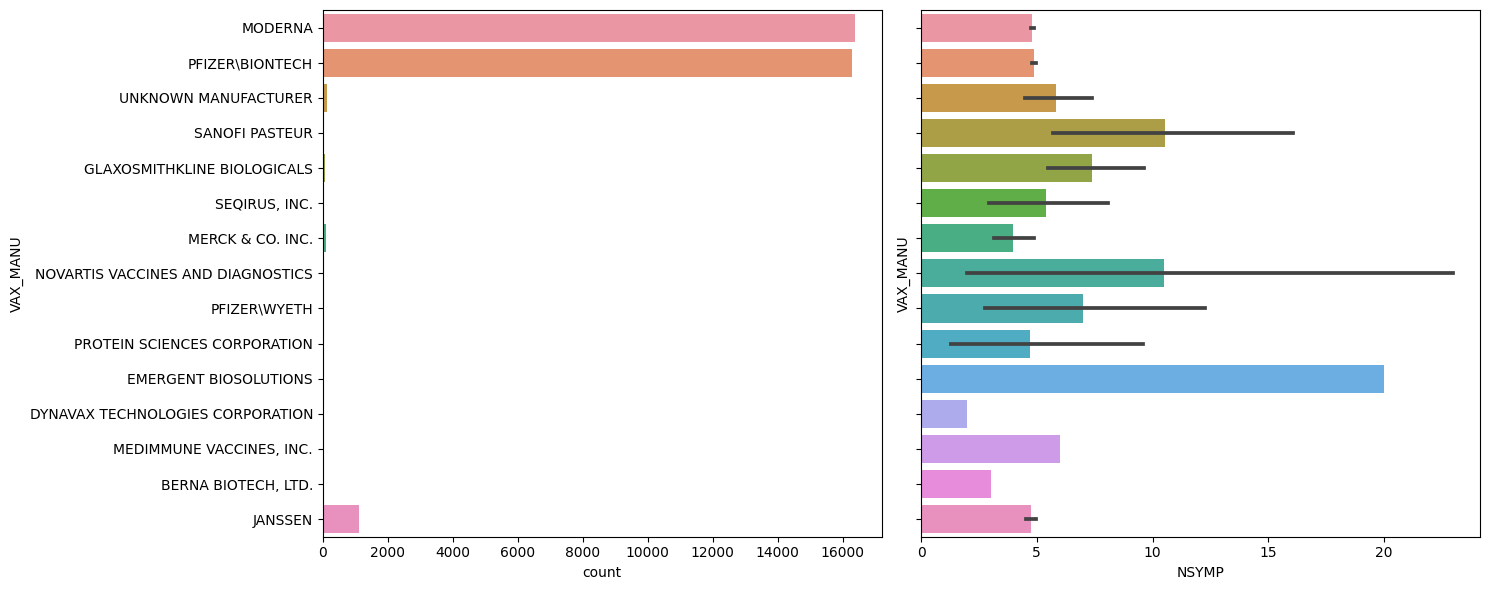

In [17]:
vaccines = np.unique(dff.VAX_MANU)
dff['NSYMP'] = dff['SYMPTOMS'].apply(len);


fig, ax = plt.subplots(1,2, figsize = (15,6), sharey = True)
sns.countplot(ax = ax[0], data = dff, y = 'VAX_MANU');
sns.barplot(ax = ax[1], data = dff, y = 'VAX_MANU', x = 'NSYMP');

plt.tight_layout();

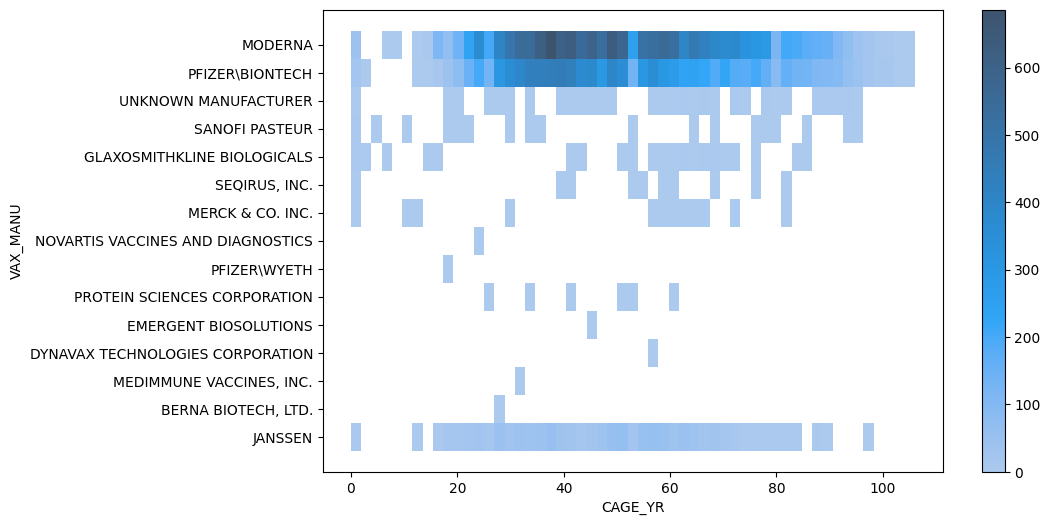

In [18]:
fig, ax = plt.subplots(1,1, figsize = (10,6), sharey = True)
sns.histplot(ax = ax, data = dff, y = 'VAX_MANU', x = 'CAGE_YR', cbar = True);
plt.show();

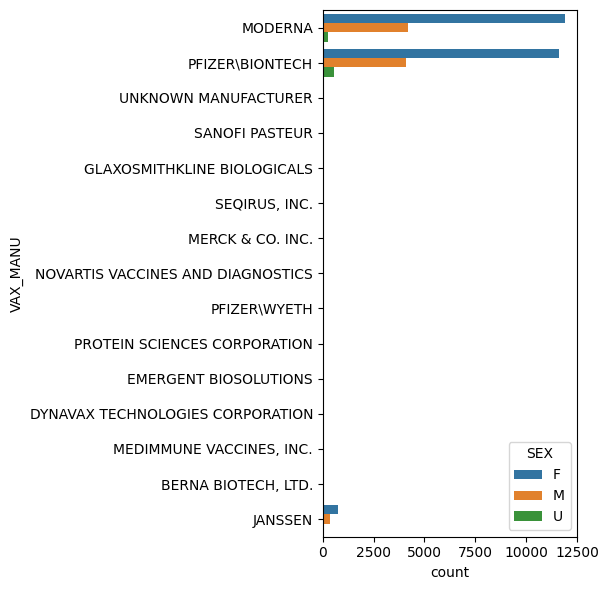

In [19]:
fig, ax = plt.subplots(1,1, figsize = (6,6), sharey = True)
sns.countplot(ax = ax, data = dff, y = 'VAX_MANU', hue = 'SEX');
plt.tight_layout();

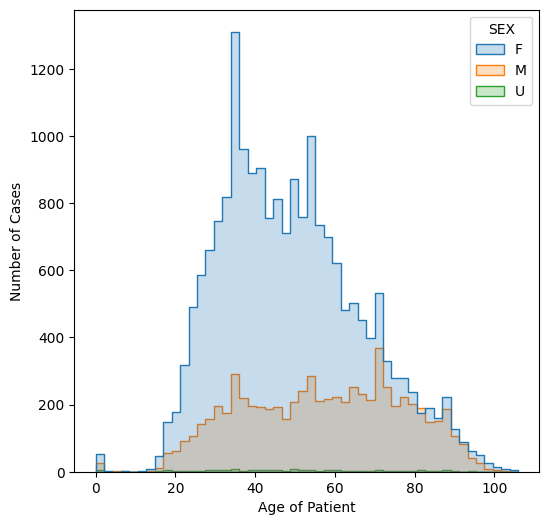

In [20]:
fig, ax = plt.subplots(1,1, figsize = (6,6), sharey = True)
sns.histplot(ax = ax, data = dff, x = 'CAGE_YR', hue = 'SEX', element = 'step', bins = 50);
ax.set_xlabel('Age of Patient')
ax.set_ylabel('Number of Cases')
plt.show();

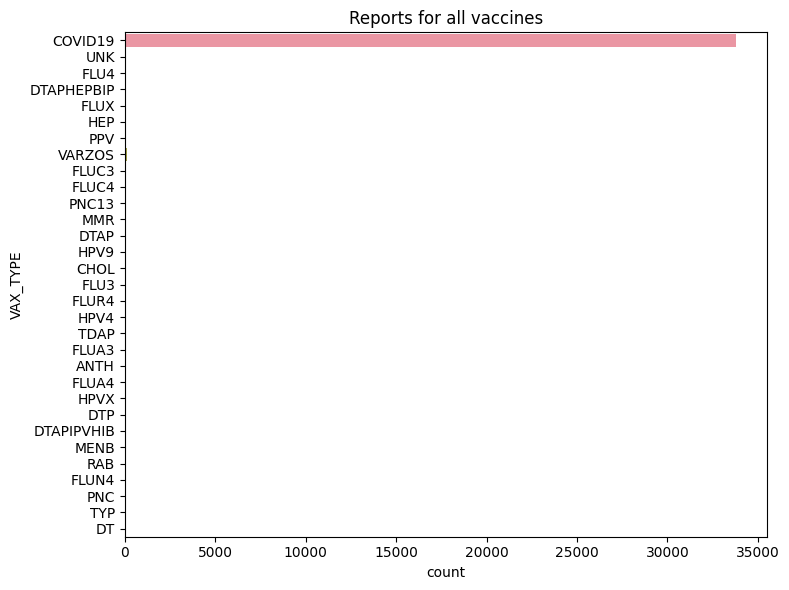

In [21]:
fig, ax = plt.subplots(1,1, figsize = (8,6), sharey = True)
sns.countplot(ax = ax, data = dff, y = 'VAX_TYPE');
ax.set_title('Reports for all vaccines')
plt.tight_layout();

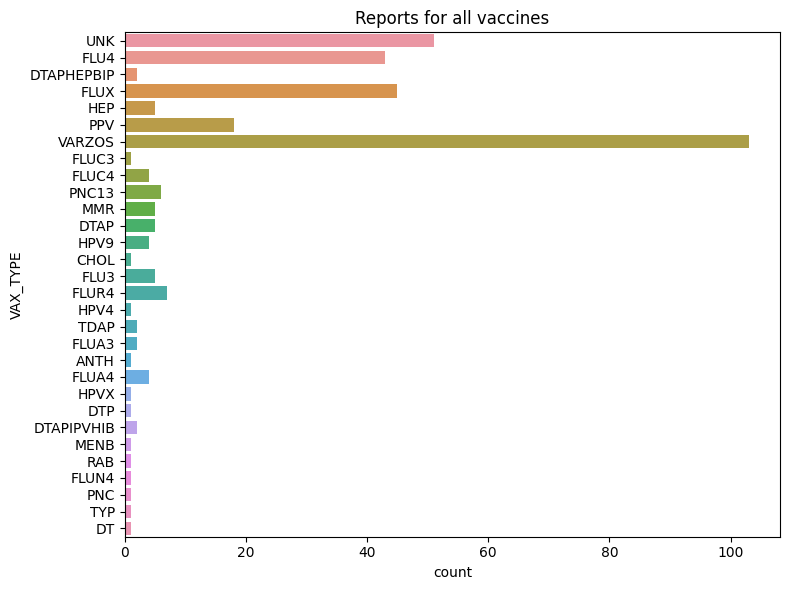

In [22]:
fig, ax = plt.subplots(1,1, figsize = (8,6), sharey = True)
sns.countplot(ax = ax, data = dff[dff.VAX_TYPE != 'COVID19'], y = 'VAX_TYPE');
ax.set_title('Reports for all vaccines')
plt.tight_layout();

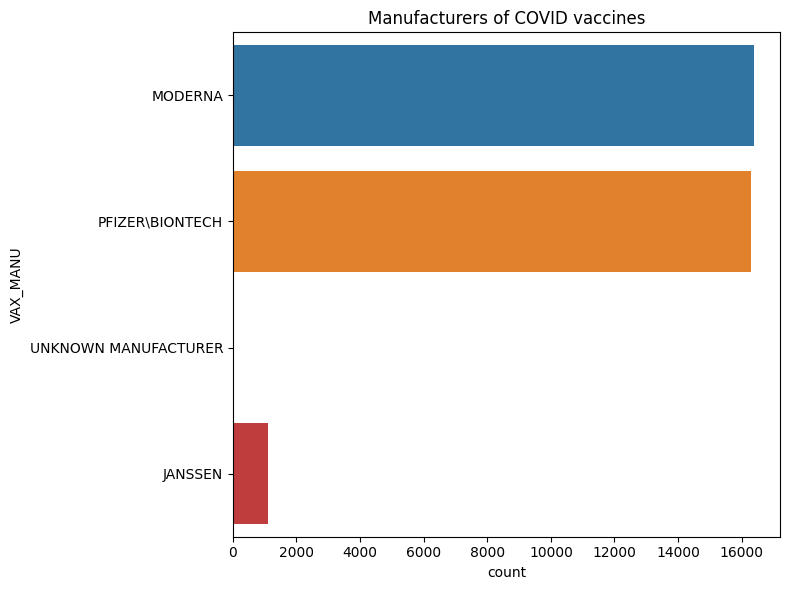

In [23]:
fig, ax = plt.subplots(1,1, figsize = (8,6), sharey = True)
sns.countplot(ax = ax, data = dff[dff.VAX_TYPE == 'COVID19'], y = 'VAX_MANU');
ax.set_title('Manufacturers of COVID vaccines')
plt.tight_layout();

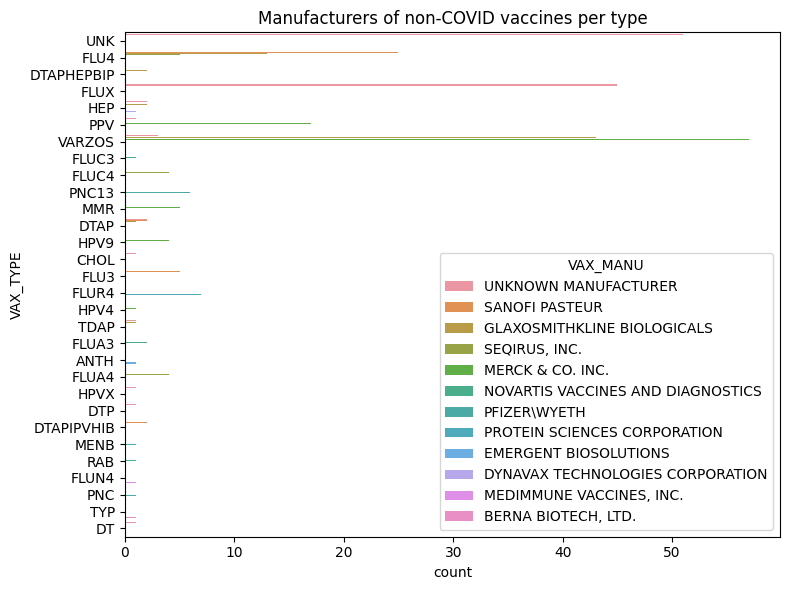

In [24]:
fig, ax = plt.subplots(1,1, figsize = (8,6), sharey = True)
sns.countplot(ax = ax, data = dff[dff.VAX_TYPE != 'COVID19'], y = 'VAX_TYPE', hue = 'VAX_MANU');
ax.set_title('Manufacturers of non-COVID vaccines per type')
plt.tight_layout();

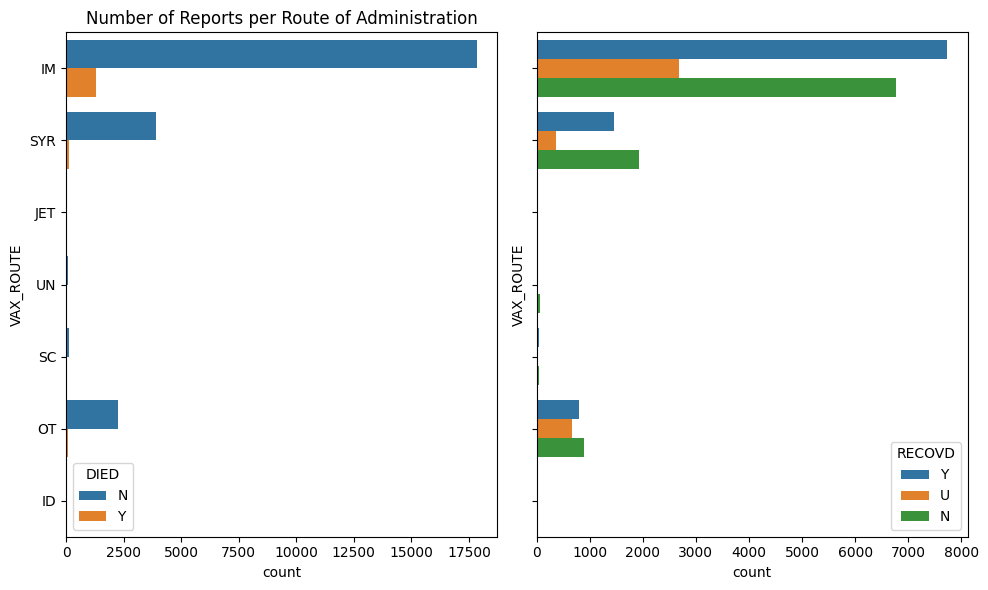

In [25]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = True)
var = 'DIED'
dff[var][dff[var] != 'Y'] = 'N'
sns.countplot(ax = ax[0], data = dff, y = 'VAX_ROUTE', hue = 'DIED');
sns.countplot(ax = ax[1], data = dff, y = 'VAX_ROUTE', hue = 'RECOVD');
ax[0].set_title('Number of Reports per Route of Administration')
plt.tight_layout();

These are some of the most common words found in the database indicating the non existance of a value:

In [26]:
NegL = ['NaN', 'nan', 'None', 'none', 'no known', 'Known Known', 'UKN', 'None noted', 'NA', 'Not known', 'No known allergies.', 'No known allergies', 'not known', 'notknown', 'NKA', 'NKDA', 'No', 'NO', 'none listed', 'none lister', 'NONE', 'none reported']

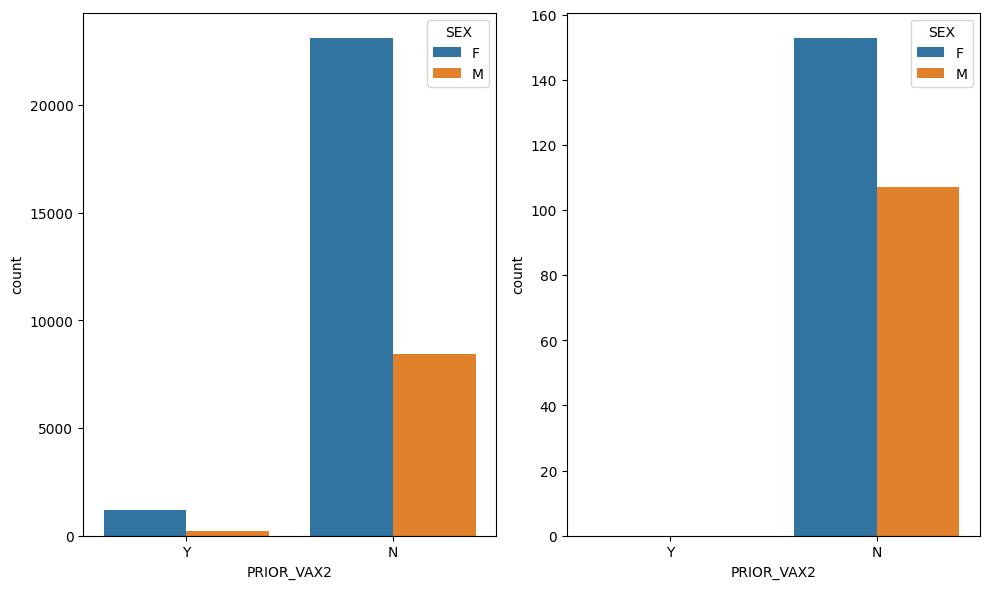

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=False)
var = 'PRIOR_VAX'

a = []
for ix in range(len(dff)):
    try:
        a.append(np.isnan(dff[var][ix]))
    except:
        a.append(False)

var = var + '2'
dff[var] = np.where(np.array(a) == False, 'Y', 'N')

sel_covid = (dff.VAX_TYPE == 'COVID19') & (dff.SEX.isin(['F', 'M']))
hax = ax[0]
sns.countplot(ax=hax, data=dff[sel_covid], x=var, hue='SEX', order=['Y', 'N'], hue_order=['F', 'M'])

sel_non_covid = (dff.VAX_TYPE != 'COVID19') & (dff.SEX.isin(['F', 'M']))
hax = ax[1]
sns.countplot(ax=hax, data=dff[sel_non_covid], x=var, hue='SEX', order=['Y', 'N'], hue_order=['F', 'M'])

plt.tight_layout()
plt.show()


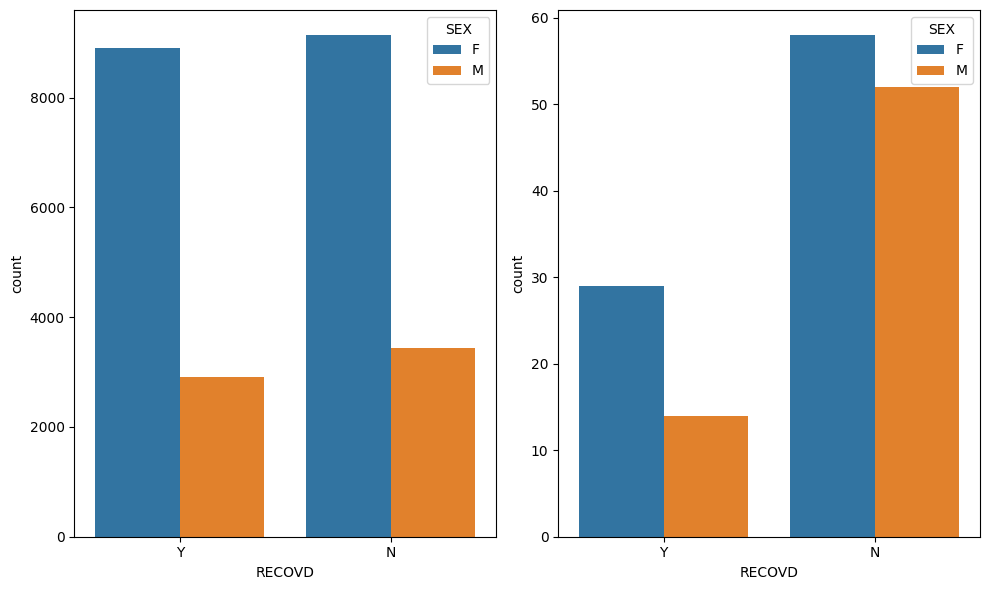

In [28]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = False)
var = 'RECOVD'
#dff[var][dff[var] != 'Y'] = 'N'

sel = (dff.VAX_TYPE == 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])

sel = (dff.VAX_TYPE != 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
plt.tight_layout()

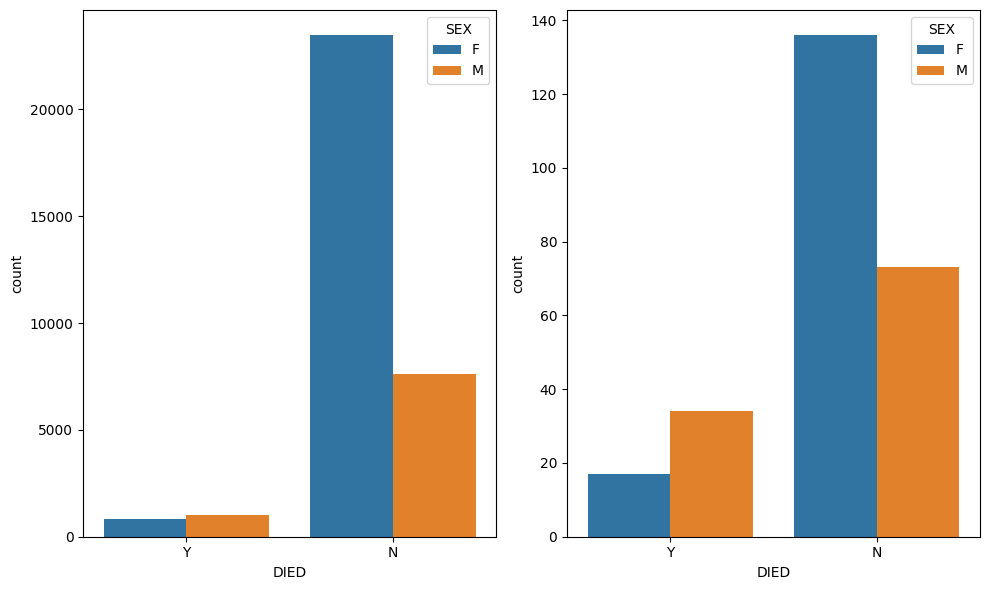

In [29]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = False)
var = 'DIED'
dff[var][dff[var] != 'Y'] = 'N'

sel = (dff.VAX_TYPE == 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])

sel = (dff.VAX_TYPE != 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
plt.tight_layout()

of those who didn't recover, how many died?

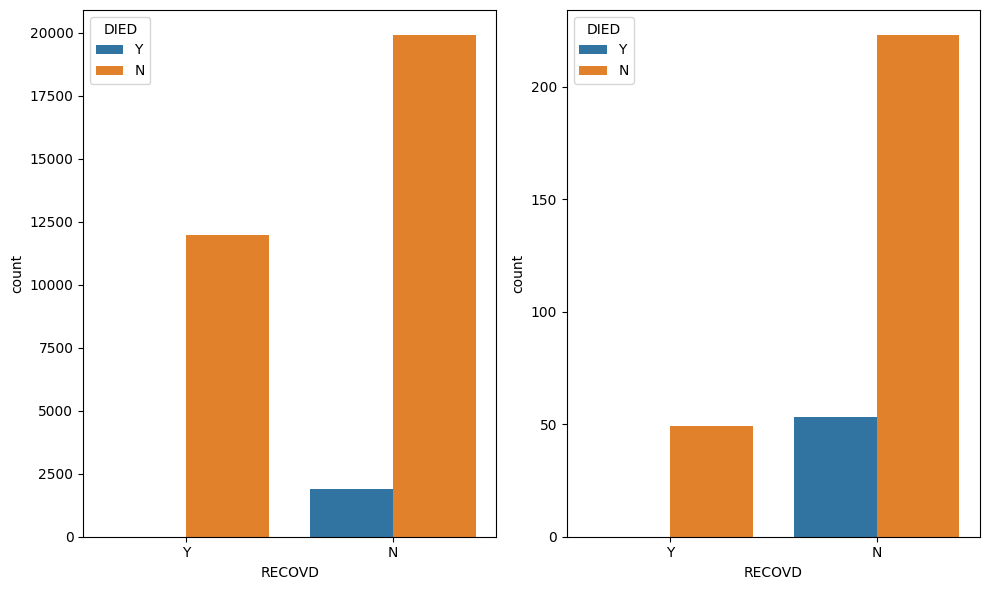

In [30]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = False)
var = 'RECOVD'
dff[var][dff[var] != 'Y'] = 'N'

sel = (dff.VAX_TYPE == 'COVID19')
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'DIED', order = ['Y', 'N'], hue_order = ['Y', 'N'])

sel = (dff.VAX_TYPE != 'COVID19')
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'DIED', order = ['Y', 'N'], hue_order = ['Y', 'N'])
plt.tight_layout()

How did recover those with specific manufacturers?

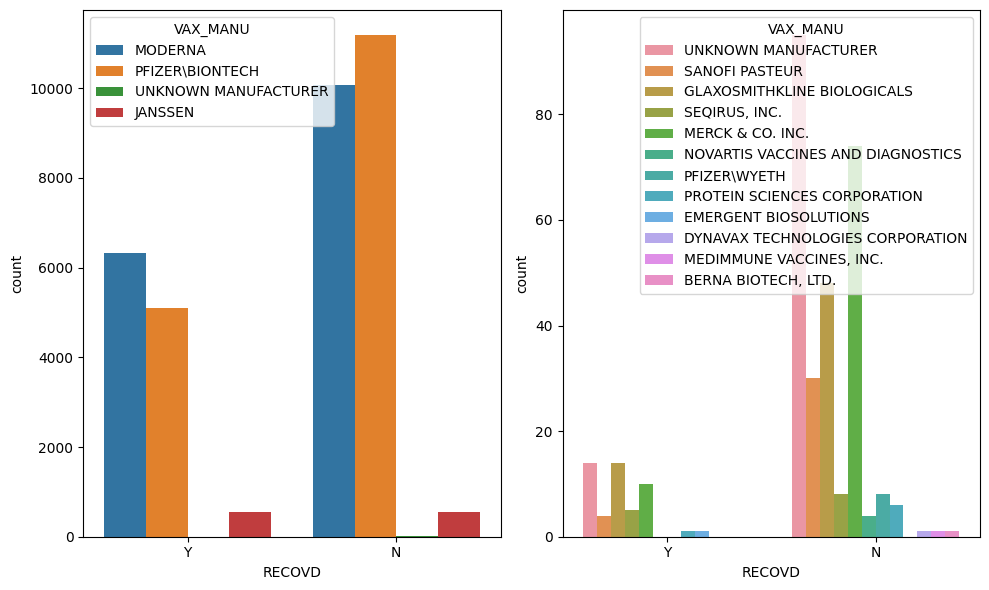

In [31]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = False)
var = 'RECOVD'
dff[var][dff[var] != 'Y'] = 'N'

sel = (dff.VAX_TYPE == 'COVID19')
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'VAX_MANU', order = ['Y', 'N'])

sel = (dff.VAX_TYPE != 'COVID19')
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'VAX_MANU', order = ['Y', 'N'])
plt.tight_layout()

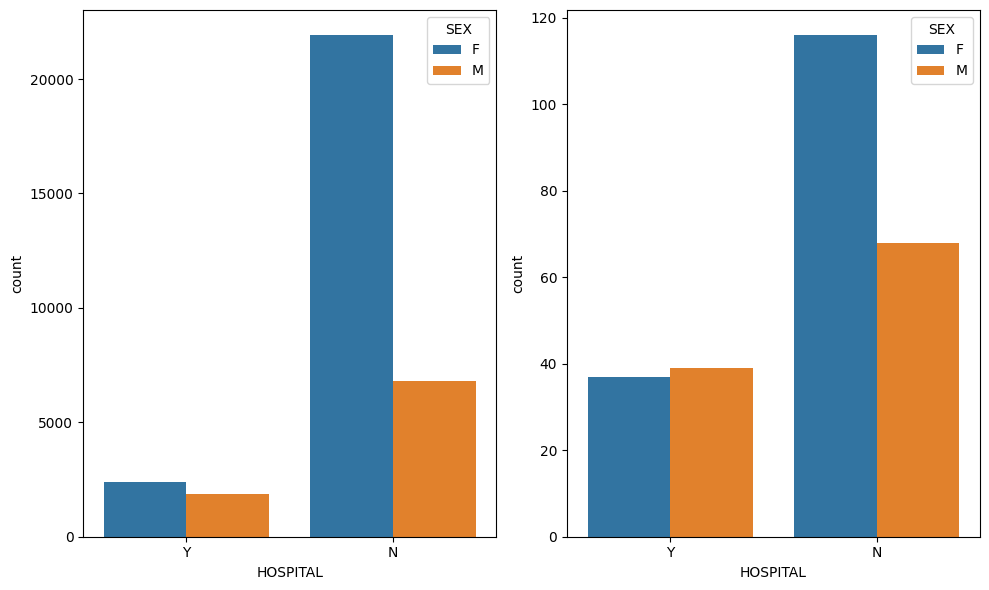

In [32]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = False)
var = 'HOSPITAL'
dff[var][dff[var] != 'Y'] = 'N'

sel = (dff.VAX_TYPE == 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])

sel = (dff.VAX_TYPE != 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
plt.tight_layout()

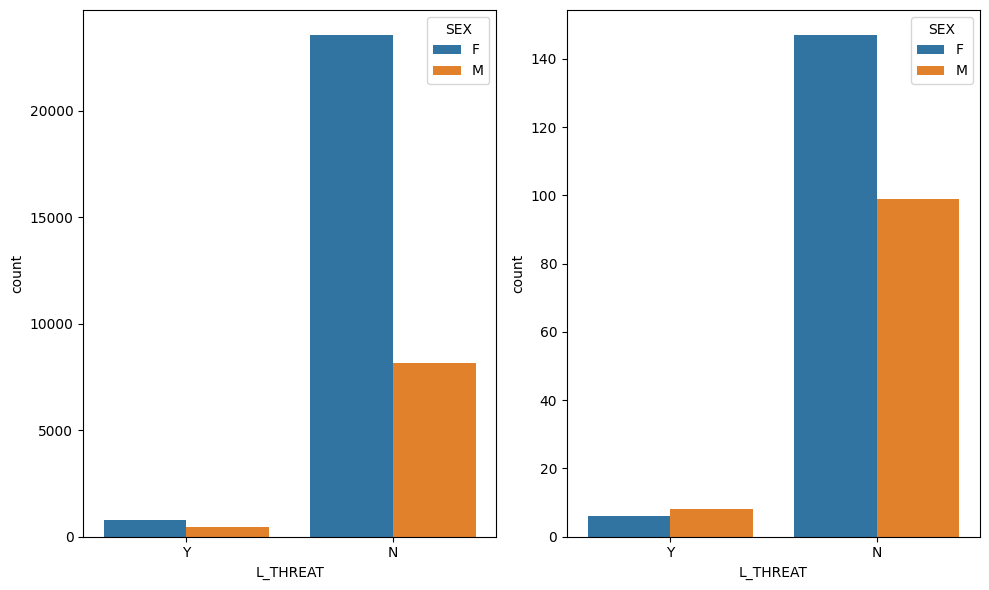

In [33]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = False)
var = 'L_THREAT'
dff[var][dff[var] != 'Y'] = 'N'

sel = (dff.VAX_TYPE == 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])

sel = (dff.VAX_TYPE != 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
plt.tight_layout()

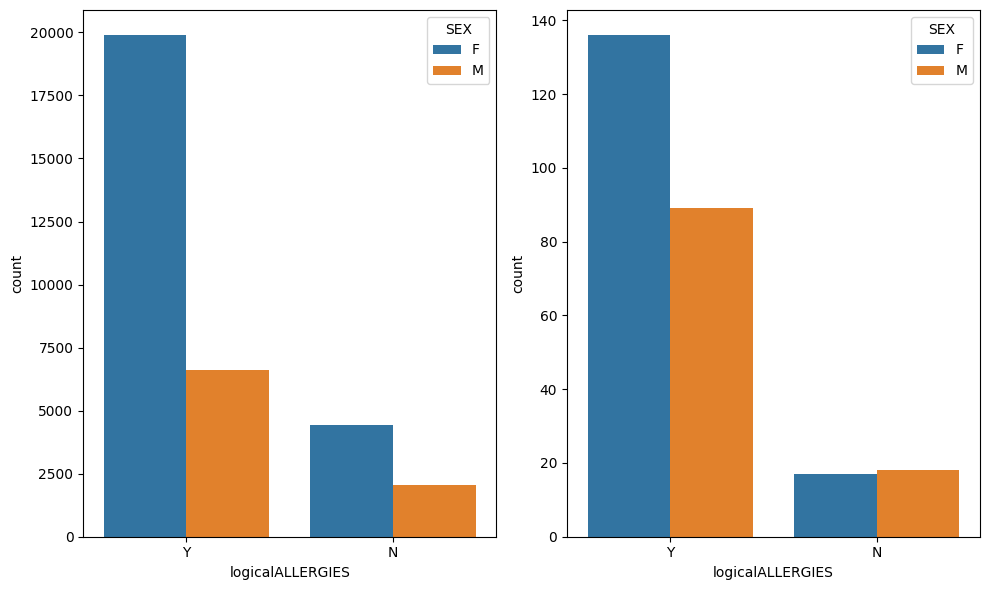

In [34]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = False)
var = 'logicalALLERGIES'
dff[var] = np.repeat(np.nan, len(dff))
dff[var][np.in1d(dff.ALLERGIES, NegL)] = 'N'
dff[var][dff[var] != 'N'] = 'Y'

sel = (dff.VAX_TYPE == 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])

sel = (dff.VAX_TYPE != 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
plt.tight_layout()

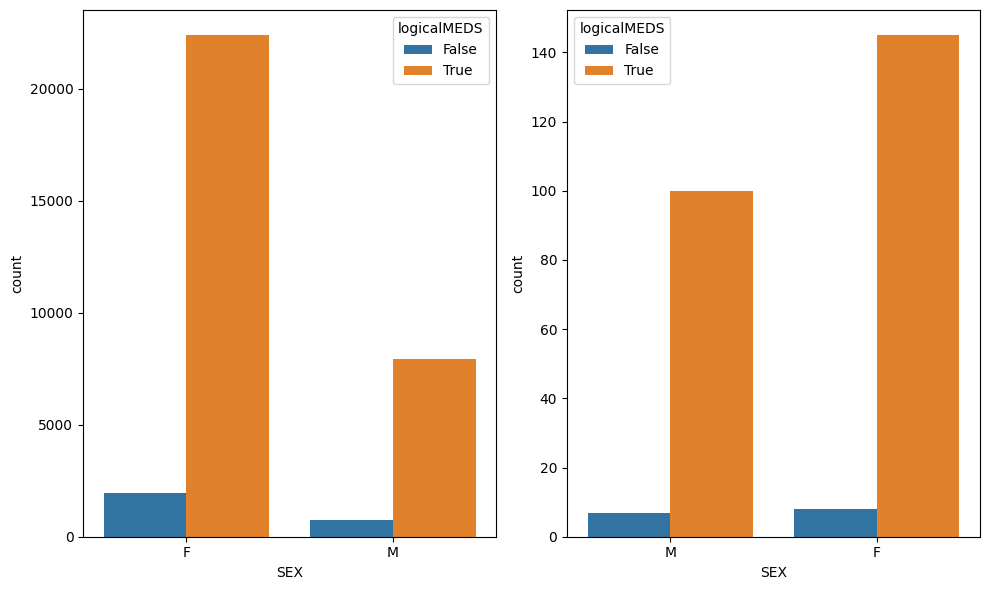

In [35]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = False)
var = 'logicalMEDS'
dff[var] = np.in1d(dff.OTHER_MEDS, NegL) == False
sel = (dff.VAX_TYPE == 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = 'SEX', hue = var)

sel = (dff.VAX_TYPE != 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = 'SEX', hue = var)
plt.tight_layout()

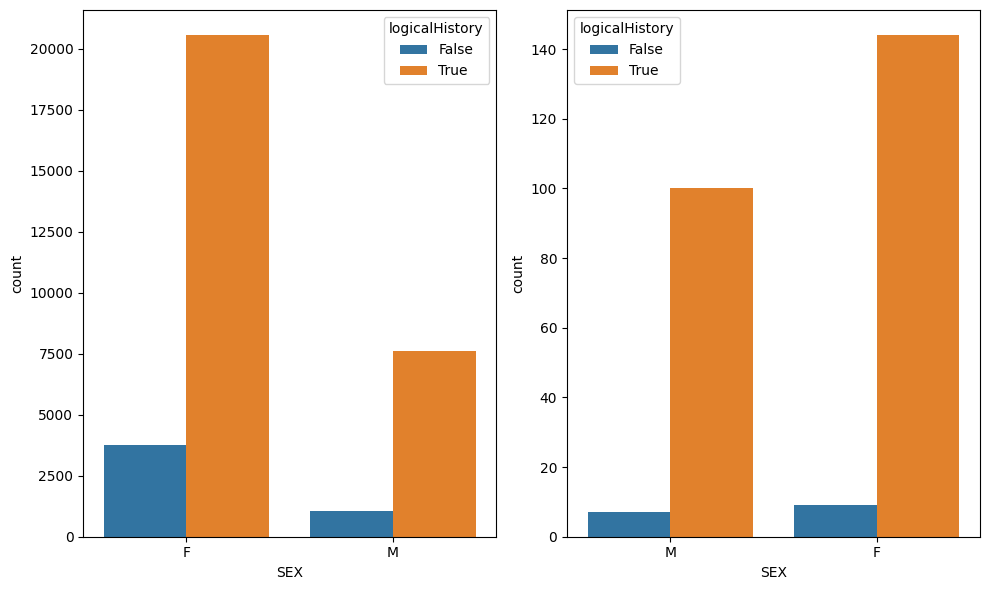

In [36]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = False)
var = 'logicalHistory'
dff[var] = np.in1d(dff.HISTORY, NegL) == False
sel = (dff.VAX_TYPE == 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = 'SEX', hue = var)

sel = (dff.VAX_TYPE != 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = 'SEX', hue = var)
plt.tight_layout()

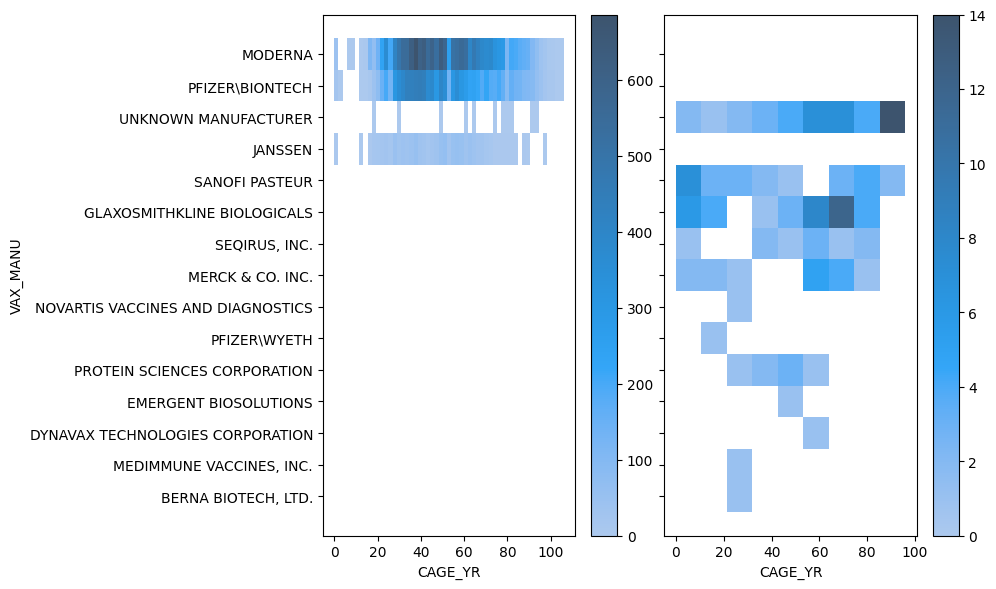

In [37]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = True)
sns.histplot(ax = ax[0], data = dff[dff.VAX_TYPE == 'COVID19'], y = 'VAX_MANU', x = 'CAGE_YR', cbar = True);
sns.histplot(ax = ax[1], data = dff[dff.VAX_TYPE != 'COVID19'], y = 'VAX_MANU', x = 'CAGE_YR', cbar = True);
plt.tight_layout();

In [38]:
import nltk
from nltk.stem import WordNetLemmatizer
# Download NLTK resources
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('stopwords');

from nltk.corpus import stopwords;
stopwords = stopwords.words('english') + ['of','the','to','be','that','with','on','for','by','at','one', 's', 't', 'n', 'nt', 'don', 'doesn'];

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Preprocess text data within each list
def preprocess_text_list(text_list):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word.lower()) for word in text_list if word.lower() not in stopwords])

# Apply preprocessing to the 'symptoms' column (assuming 'symptoms' is a list column)
dff['bSympt'] = dff['SYMPTOMS'].apply(preprocess_text_list)


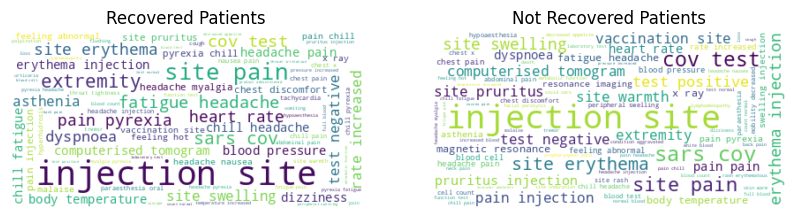

In [40]:
# Assuming 'dff' is your DataFrame containing the data
# Assuming 'stopwords' is your list of stopwords

# Create a WordCloud instance
wc = WordCloud(background_color='white', stopwords=stopwords)

fig, ax = plt.subplots(1,2, figsize = (10,10), sharey = True)

var = 'RECOVD'
# Create the WordCloud from the combined strings
combined_text = ' '.join(dff.bSympt[dff[var] == 'Y'])
wc.generate(combined_text)

# Display the WordCloud
ax[0].imshow(wc, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('Recovered Patients')

# Create the WordCloud from the combined strings
combined_text = ' '.join(dff.bSympt[dff[var] == 'N'])
wc.generate(combined_text)

# Display the WordCloud
ax[1].imshow(wc, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title('Not Recovered Patients')

plt.show()


In [48]:
# Split the data into training and testing sets
X = dff['bSympt']
y = dff['RECOVD'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

classifier = RandomForestClassifier()
classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.67
              precision    recall  f1-score   support

           N       0.71      0.82      0.77      6671
           Y       0.54      0.38      0.45      3566

    accuracy                           0.67     10237
   macro avg       0.63      0.60      0.61     10237
weighted avg       0.65      0.67      0.65     10237



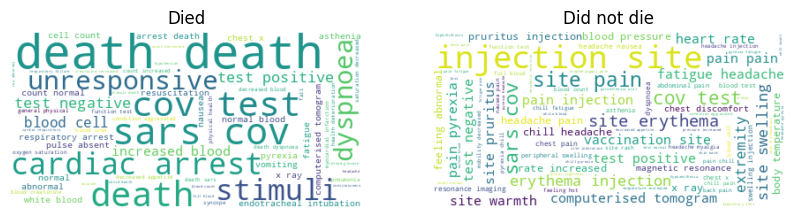

In [42]:
# Assuming 'dff' is your DataFrame containing the data
# Assuming 'stopwords' is your list of stopwords

# Create a WordCloud instance
wc = WordCloud(background_color='white', stopwords=stopwords)

fig, ax = plt.subplots(1,2, figsize = (10,10), sharey = True)

var = 'DIED'
# Create the WordCloud from the combined strings
combined_text = ' '.join(dff.bSympt[dff[var] == 'Y'])
wc.generate(combined_text)

# Display the WordCloud
ax[0].imshow(wc, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('Died')

# Create the WordCloud from the combined strings
combined_text = ' '.join(dff.bSympt[dff[var] == 'N'])
wc.generate(combined_text)

# Display the WordCloud
ax[1].imshow(wc, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title('Did not die')

plt.show()


In [47]:
# Split the data into training and testing sets
X = dff['bSympt']
y = dff['DIED'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

classifier = RandomForestClassifier()
classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.99
              precision    recall  f1-score   support

           N       0.99      1.00      1.00      9666
           Y       0.96      0.88      0.92       571

    accuracy                           0.99     10237
   macro avg       0.98      0.94      0.96     10237
weighted avg       0.99      0.99      0.99     10237

